<div align="center">
    
---
# Title Here
</div>

---
## Problem Context
---

text

---
## Data Source
---

Text

---
## Module Imports
---

In [1]:
%reload_ext autoreload
%autoreload 2

In [20]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [21]:
from ucimlrepo import fetch_ucirepo #load the function to fetch datasets from UCI ML Repository
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *  #import all functions from utils.py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import dice_ml
from dice_ml.utils import helpers
#from witwidget.notebook.visualization import WitConfigBuilder, WitWidget


---

In [22]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 

In [23]:
heart_disease.metadata

{'uci_id': 45,
 'name': 'Heart Disease',
 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease',
 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv',
 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach',
 'area': 'Health and Medicine',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 303,
 'num_features': 13,
 'feature_types': ['Categorical', 'Integer', 'Real'],
 'demographics': ['Age', 'Sex'],
 'target_col': ['num'],
 'index_col': None,
 'has_missing_values': 'yes',
 'missing_values_symbol': 'NaN',
 'year_of_dataset_creation': 1989,
 'last_updated': 'Fri Nov 03 2023',
 'dataset_doi': '10.24432/C52P4X',
 'creators': ['Andras Janosi',
  'William Steinbrunn',
  'Matthias Pfisterer',
  'Robert Detrano'],
 'intro_paper': {'ID': 231,
  'type': 'NATIVE',
  'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.',
  'authors': 'R. Detr

In [24]:
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [25]:
X = pd.DataFrame(data=heart_disease.data.features, columns=heart_disease.feature_names)
y = pd.DataFrame(heart_disease.data.targets, columns=heart_disease.target_names)

# Combine
df = pd.concat([X, y], axis=1)

df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


In [26]:
sex_mapping = {0: 'female', 1: 'male'}
df['sex_str'] = df['sex'].map(sex_mapping)

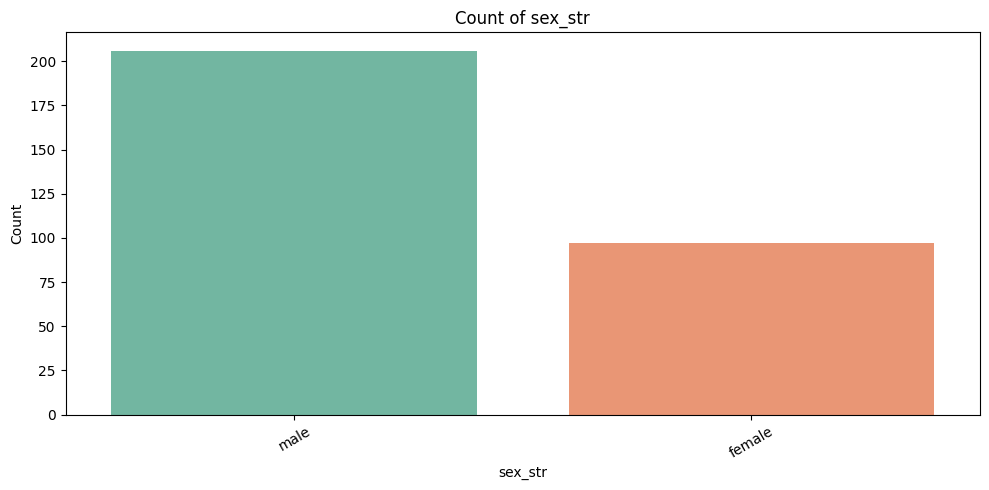

In [27]:
plot_feature_distribution_categorical(df, 'sex_str')

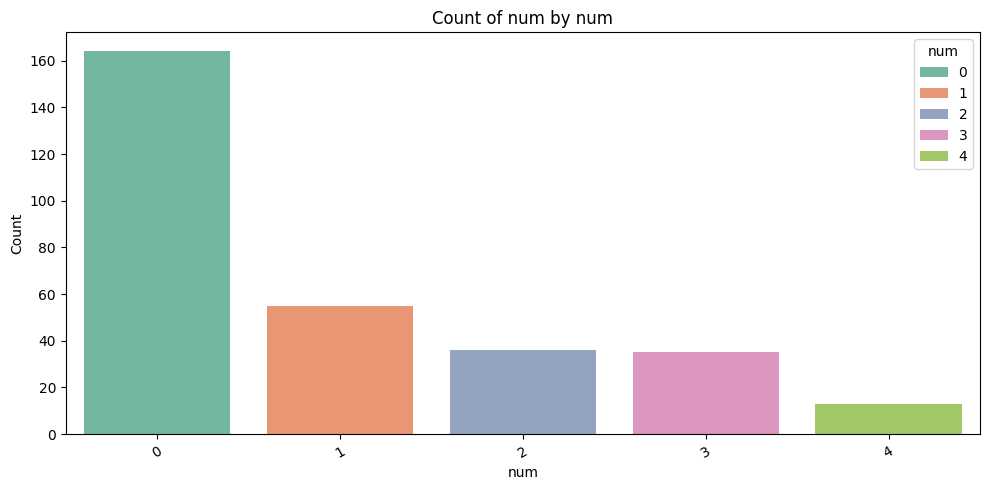

In [28]:
plot_feature_distribution_categorical(df, 'num', target='num')

The target variable ranges from 0 to 4, where 0 indicates no heart disease and values 1 through 4 represent increasing levels of disease severity. However, most studies and implementations based on this dataset simplify the problem into a binary classification task. Specifically, all non-zero values (1–4) are grouped together and treated as “disease present,” while 0 remains “no disease.” This transformation is widely adopted because the dataset is relatively small and the higher severity classes contain very few samples, which makes multi-class modeling unstable and prone to imbalance. Moreover, for most practical and clinical purposes, the key question is whether a patient has heart disease at all, rather than predicting the precise severity level. Converting the target variable to binary form therefore improves model reliability, simplifies interpretation, and aligns with the primary goal of identifying the presence of heart disease, which is especially relevant for fairness and counterfactual analysis.


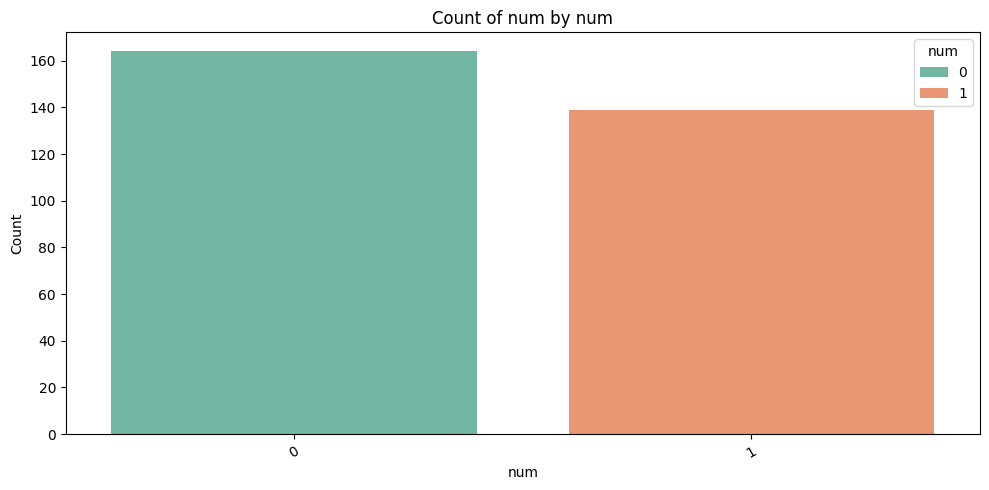

In [29]:
# Collapse multi-class target into binary
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
plot_feature_distribution_categorical(df, 'num', target='num')

---

In [30]:
df = df.drop(columns=['sex_str'])

In [31]:
X = df.drop(columns=['num'])
y = df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
#print("Classification Report:")
#print(classification_report(y_test, y_pred))